In [237]:
import datetime as dt
import re
import pandas as pd
from numpy import nan
import matplotlib.pyplot as plt


def containsNumber(value):
    for character in value:
        if character.isdigit():
            return True
    return False


def get_high_reps(s):
    if "," in s:
        reps = [float(x) for x in s.split(",")]
        return float(max(reps))

    elif "x" in s:
        return float(s.split("x")[-1])

    else:
        return float(s)


# import data from notes and put it in a list
with open("data/liftingpostcovid.txt", "r") as data:
    rawNotes = [(line.strip()).split() for line in data]
rawNotes = [x for x in rawNotes if x]

curr_date = dt.datetime.strptime("1/1/20", "%m/%d/%y")
data = []
for row in rawNotes:
    lift = []
    weight = None
    reps = None
    notes = []
    try:
        for val in row:
            if "/" in val and len(row) == 1:
                curr_date = dt.datetime.strptime(val, "%m/%d/%y")
                day = True
                break
            elif re.fullmatch(r"^\D*$", val) and not weight:
                lift.append(val.lower())

            elif containsNumber(val) and ',' not in val and not weight:
                _ = re.sub(r"[^\d.]", "", val)
                weight = float(_)

            elif containsNumber(val) and ":" not in val and not reps:
                reps = min(get_high_reps(val), 15)
            else:
                notes.append(val)
        lift = " ".join(lift)
        if notes:
            notes = " ".join(notes)
        else:
            notes = None
        data.append((curr_date, lift, weight, reps, notes))
    except Exception as e:
        print(row, e, curr_date)

df = pd.DataFrame(data, columns=["date", "lift", "weight", "high_reps", "notes"])
df['high_reps'] = df['high_reps'].fillna(0)
df["e1rm"] = round(df["weight"] * (36 / (37 - df["high_reps"].clip(0,13))), 1)
df.loc[df.high_reps <= 0, 'e1rm'] = nan

print(df.tail(5))


['OHP', '115', '3x3+1'] could not convert string to float: '3+1' 2016-11-10 00:00:00
['OHP', '115', '7,6+1,7'] could not convert string to float: '6+1' 2016-12-07 00:00:00
['OHP', '135', '3+1,4,2+1'] could not convert string to float: '3+1' 2016-12-10 00:00:00
['12:55', '3k'] could not convert string to float: '3k' 2016-12-10 00:00:00
['7:55', '2k'] could not convert string to float: '2k' 2016-12-10 00:00:00
['OHP', '135', '4,3+1,3+1'] could not convert string to float: '3+1' 2016-12-16 00:00:00
['Row', '12', 'min', '2.7k'] could not convert string to float: '2.7k' 2018-10-12 00:00:00
['Mile', 'run', '9:27', 'hr', '165-175'] could not convert string to float: '165-175' 2018-12-01 00:00:00
           date                lift  weight  high_reps notes   e1rm
8424 2024-07-18           ham curls     NaN        0.0  None    NaN
8425 2024-07-18            quad ext     NaN        0.0  None    NaN
8426 2024-07-18  hanging leg raises     NaN       10.0  None    NaN
8427 2024-07-18      suitcase 

In [238]:
df = df.loc[~(df.lift == '')].copy()
df['weight'] = df['weight'].fillna(0)
df

,date,lift,weight,high_reps,notes,e1rm
1,2015-09-07,squat,245.0,1.0,None,245.0
2,2015-09-07,deadlift,195.0,3.0,None,206.5
3,2015-09-07,pullups,77.0,0.0,None,NaN
4,2015-09-07,curls,65.0,10.0,ish,86.7
6,2015-09-08,front squat,195.0,1.0,None,195.0
...,...,...,...,...,...,...
8424,2024-07-18,ham curls,0.0,0.0,None,NaN
8425,2024-07-18,quad ext,0.0,0.0,None,NaN
8426,2024-07-18,hanging leg raises,0.0,10.0,None,NaN
8427,2024-07-18,suitcase carry,32.0,2.0,None,32.9


In [239]:
df.loc[~(df.e1rm.isna()) & (df.lift.str.contains('curl'))].sort_values(by='e1rm').tail(15)

,date,lift,weight,high_reps,notes,e1rm
5986,2022-04-23,curls,95.0,8.0,None,117.9
5842,2022-03-16,curls,95.0,8.0,None,117.9
6002,2022-04-28,curls,105.0,5.0,None,118.1
5814,2022-03-11,curls,90.0,10.0,None,120.0
5751,2022-02-27,bb curls,90.0,10.0,None,120.0
5866,2022-03-21,curls,90.0,10.0,None,120.0
5772,2022-03-02,curls,90.0,10.0,None,120.0
6042,2022-05-10,curls,80.0,15.0,100,120.0
6025,2022-05-04,curls,110.0,4.0,None,120.0
6091,2022-05-19,curls,115.0,3.0,None,121.8


In [240]:
df['day'] = df['date'] - pd.to_datetime('2015-09-01')
df['week'] = df['day'].dt.days.astype(int) // 7

<Axes: xlabel='Date', ylabel='Estimated rdl 1 Rep Max'>

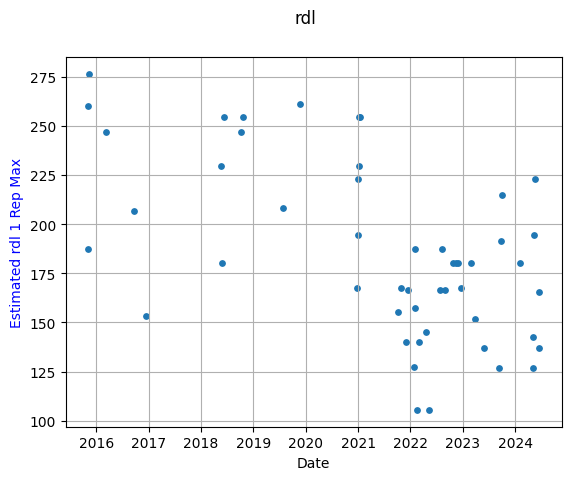

In [241]:
def plot_lift(lift_name, df):
    df = df.loc[df.lift==lift_name].copy(deep=True).reset_index(drop=True)
    plt.figure()
    plt.scatter(df['date'], df['e1rm'], s=15)
    plt.xlabel("Date")
    plt.ylabel("Estimated " + str(lift_name) + " 1 Rep Max", color='blue')
    ax1 = plt.gca()
    n = 1  # Keeps every nth label
    [
        l.set_visible(False)
        for (i, l) in enumerate(ax1.xaxis.get_ticklabels())
        if i % n != 0
    ]
    plt.grid(True)
    plt.suptitle(lift_name)
    plt.savefig(f'plots/{lift_name}_e1RM')
    #ax.table(cellText=data, colLabels=column_labels, loc="center")
    return ax1

plot_lift('rdl', df)

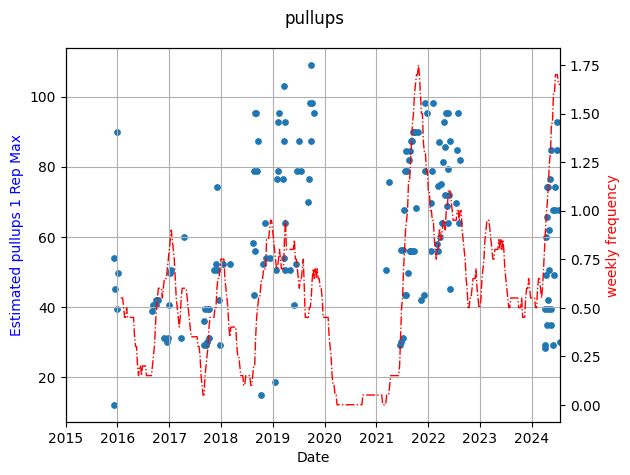

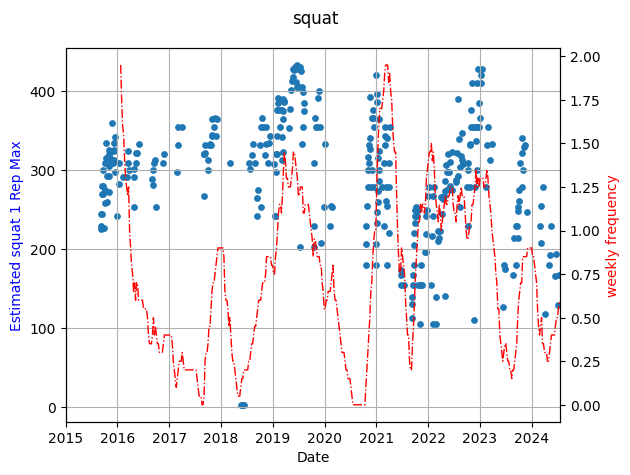

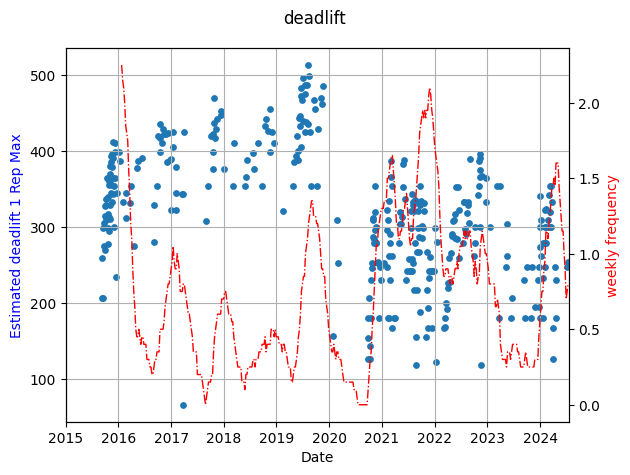

In [242]:
def freq_and_strength(df,lift):

    ax1 = plot_lift(lift, df)
    ax1.set_xlim([pd.to_datetime('2015-01-01'), df['date'].max()])
    bench = df.loc[df.lift == lift].groupby(pd.Grouper(key='date', freq='D'))['lift'].value_counts().reset_index()
    bench = bench.set_index('date').resample("1D").asfreq().fillna(0).reset_index()
    y = bench.groupby(pd.Grouper(key='date', freq='W'))['count'].sum().reset_index()
    y['avg'] = y['count'].rolling(20).mean()

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    ax2.set_ylabel('weekly frequency', color='red')  # we already handled the x-label with ax1
    ax2.plot(y['date'], y['avg'], color='red', linestyle='-.', linewidth=1)
    ax2.tick_params(axis='y')
    fig = plt.gcf()
    fig.tight_layout()
    plt.show()

    #display(y.sort_values(by='count'))
    return
freq_and_strength(df,'pullups')
freq_and_strength(df,'squat')
freq_and_strength(df,'deadlift')

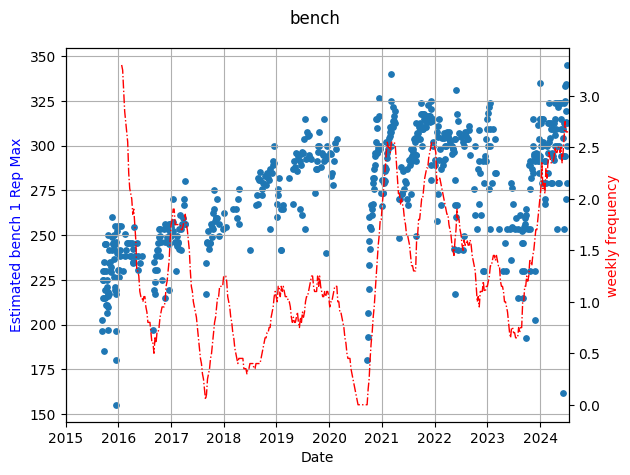

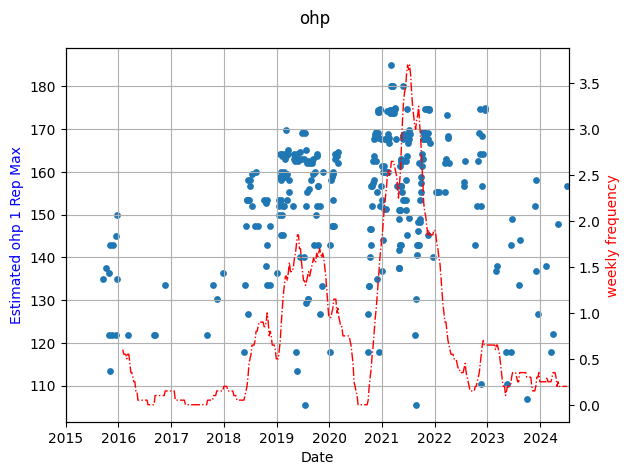

In [243]:
freq_and_strength(df,'bench')
freq_and_strength(df,'ohp')

,date,lifted,avg
0,2015-09-13,6.0,6.000000
1,2015-09-20,6.0,6.000000
2,2015-09-27,6.0,6.000000
3,2015-10-04,5.0,5.750000
4,2015-10-11,6.0,5.800000
...,...,...,...
458,2024-06-23,5.0,4.416667
459,2024-06-30,5.0,4.416667
460,2024-07-07,3.0,4.333333
461,2024-07-14,4.0,4.333333


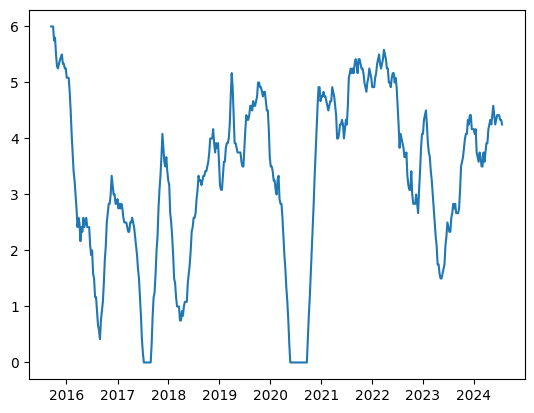

In [244]:
test = df[['date']].copy(deep=True)
test['lifted'] = 1
test = test.drop_duplicates()
test = test.set_index('date').resample("1D").asfreq().fillna(0).reset_index()
y = test.groupby(pd.Grouper(key='date', freq='W'))['lifted'].sum().reset_index()
y['avg'] = y['lifted'].rolling(12,min_periods=1).mean()
display(y)
plt.plot(y['date'],y['avg'])

In [245]:
y['lifted'].value_counts()

lifted
5.0    100
4.0     83
0.0     82
6.0     63
3.0     60
2.0     44
1.0     30
7.0      1
Name: count, dtype: int64

In [246]:
y.loc[y.date.dt.year == 2024].sort_values(by=['lifted', 'avg']).tail(25)

,date,lifted,avg
437,2024-01-28,3.0,3.666667
434,2024-01-07,3.0,4.083333
455,2024-06-02,3.0,4.250000
462,2024-07-21,3.0,4.250000
460,2024-07-07,3.0,4.333333
454,2024-05-26,3.0,4.416667
441,2024-02-25,4.0,3.500000
448,2024-04-14,4.0,4.166667
449,2024-04-21,4.0,4.250000
450,2024-04-28,4.0,4.333333


In [247]:
y.tail(20)

,date,lifted,avg
443,2024-03-10,5.0,3.750000
444,2024-03-17,3.0,3.583333
445,2024-03-24,5.0,3.750000
446,2024-03-31,5.0,3.916667
447,2024-04-07,5.0,3.916667
448,2024-04-14,4.0,4.166667
449,2024-04-21,4.0,4.250000
450,2024-04-28,4.0,4.333333
451,2024-05-05,5.0,4.250000
452,2024-05-12,4.0,4.416667


In [248]:
lift = 'bench'
df.loc[df.lift==lift].groupby('high_reps')['weight'].max().reset_index().merge(
    df.loc[df.lift==lift, ['high_reps','weight','e1rm','date']]
).groupby('high_reps').first().reset_index().sort_values(by='high_reps')

,high_reps,weight,e1rm,date
0,0.00,345.0,NaN,2024-02-08
1,1.00,345.0,345.0,2024-07-09
2,1.75,295.0,301.3,2020-02-10
3,1.80,245.0,250.6,2016-02-18
4,2.00,325.0,334.3,2024-06-26
5,3.00,315.0,333.5,2024-06-23
6,4.00,295.0,321.8,2021-03-21
7,5.00,285.0,320.6,2021-12-10
8,6.00,285.0,331.0,2022-05-31
9,7.00,270.0,324.0,2021-09-25


In [249]:
df.loc[df.lift=='bench'].tail(20)

,date,lift,weight,high_reps,notes,e1rm,day,week
8244,2024-05-27,bench,245.0,7.0,None,294.0,3191 days,455
8272,2024-06-07,bench,245.0,8.0,None,304.1,3202 days,457
8273,2024-06-07,bench,135.0,7.0,None,162.0,3202 days,457
8282,2024-06-10,bench,275.0,5.0,None,309.4,3205 days,457
8301,2024-06-14,bench,225.0,5.0,None,253.1,3209 days,458
8311,2024-06-16,bench,315.0,2.0,None,324.0,3211 days,458
8312,2024-06-16,bench,295.0,3.0,None,312.4,3211 days,458
8313,2024-06-16,bench,245.0,7.0,None,294.0,3211 days,458
8327,2024-06-19,bench,325.0,1.0,None,325.0,3214 days,459
8328,2024-06-19,bench,295.0,3.0,None,312.4,3214 days,459
